In [1]:
#import lightgbm
import random
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
t = time.strftime('%m%d-%H%M', time.localtime(time.time()))
import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', 30)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정
#데이터 불러오기

df = pd.read_csv('./data/train.csv')
building_info =  pd.read_csv('./data/building_info.csv')

df = df.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}
main_time = {
    
}

building_info['building_type'] = building_info['building_type'].replace(translation_dict)


df.head()

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40


In [2]:
def merge(df):
    df = df.fillna(0)
    date = pd.to_datetime(df.date_time)
    df['hour'] = date.dt.hour
    df['day'] = date.dt.weekday
    df['month'] = date.dt.month
    df['week'] = date.dt.isocalendar().week
    
    
    # 'building_number'를 기준으로 두 데이터프레임 병합 및 전처리
    merged_df = pd.merge(df, building_info, on='building_number',how='right')
    #merge후 전처리
    merged_df['solar_power_capacity'] = merged_df['solar_power_capacity'].replace('-', 0)
    merged_df['ess_capacity'] = merged_df['ess_capacity'].replace('-', 0)
    merged_df['pcs_capacity'] = merged_df['pcs_capacity'].replace('-', 0)

    merged_df['solar_power_capacity'] = merged_df['solar_power_capacity'].astype('float64')
    merged_df['ess_capacity'] = merged_df['ess_capacity'].astype('float64')
    merged_df['pcs_capacity'] = merged_df['pcs_capacity'].astype('float64')
    
    
    return merged_df

merged_train_df0 = merge(df)
kk = merged_train_df0.loc[(merged_train_df0.building_number == 95)&(merged_train_df0.hour == 16)&(merged_train_df0.day == 2), 'power_consumption']
sum16 = kk.sum()/12
kkk = merged_train_df0.loc[(merged_train_df0.building_number == 95)&(merged_train_df0.hour == 17)&(merged_train_df0.day == 2), 'power_consumption']
sum17 = (kkk.sum()-0.36)/12
merged_train_df0.loc[(merged_train_df0.building_number == 95)&(merged_train_df0.hour == 16)&(merged_train_df0.day == 2)&(merged_train_df0.month == 7)&(merged_train_df0.week == 30), 'power_consumption'] = sum16
merged_train_df0.loc[(merged_train_df0.building_number == 95)&(merged_train_df0.hour == 17)&(merged_train_df0.day == 2)&(merged_train_df0.month == 7)&(merged_train_df0.week == 30), 'power_consumption'] = sum17
merged_train_df0

,num_date_time,building_number,date_time,temperature,rainfall,windspeed,humidity,sunshine,solar_radiation,power_consumption,hour,day,month,week,building_type,total_area,cooling_area,solar_power_capacity,ess_capacity,pcs_capacity
0,1_20220601 00,1,20220601 00,18.6,0.0,0.9,42.0,0.0,0.0,1085.28,0,2,6,22,Other Buildings,110634.00,39570.00,0.0,0.0,0.0
1,1_20220601 01,1,20220601 01,18.0,0.0,1.1,45.0,0.0,0.0,1047.36,1,2,6,22,Other Buildings,110634.00,39570.00,0.0,0.0,0.0
2,1_20220601 02,1,20220601 02,17.7,0.0,1.5,45.0,0.0,0.0,974.88,2,2,6,22,Other Buildings,110634.00,39570.00,0.0,0.0,0.0
3,1_20220601 03,1,20220601 03,16.7,0.0,1.4,48.0,0.0,0.0,953.76,3,2,6,22,Other Buildings,110634.00,39570.00,0.0,0.0,0.0
4,1_20220601 04,1,20220601 04,18.4,0.0,2.8,43.0,0.0,0.0,986.40,4,2,6,22,Other Buildings,110634.00,39570.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,0.0,0.9,86.0,0.5,0.0,881.04,19,2,8,34,Hotel and Resort,57497.84,40035.23,0.0,0.0,0.0
203996,100_20220824 20,100,20220824 20,22.4,0.0,1.3,86.0,0.0,0.0,798.96,20,2,8,34,Hotel and Resort,57497.84,40035.23,0.0,0.0,0.0
203997,100_20220824 21,100,20220824 21,21.3,0.0,1.0,92.0,0.0,0.0,825.12,21,2,8,34,Hotel and Resort,57497.84,40035.23,0.0,0.0,0.0
203998,100_20220824 22,100,20220824 22,21.0,0.0,0.3,94.0,0.0,0.0,640.08,22,2,8,34,Hotel and Resort,57497.84,40035.23,0.0,0.0,0.0


태양광 설비가 되있는곳은 다음날에 사용된다. -> 동준이가 상관계수 분석한걸 보면 다음날 전력사용량과 전일 일조량간의 뚜렷한 반비례관계가 나타남

 ess와pcs가 있다면 더 유의미한게 있지않을까? 상관관계를 알아봐야할거같은데-> 아무 의미 없는듯 어쨋든 발전을 해야 이 설비가 의미가 있는거임

 따라서 전일의 sunshine의 평균이 0.5이상이면 solar_on을 1로 하고 아니면 0으로 하는거임 태양광 발전은 일사량이 더 중요하기 때문에 이렇게만

 

In [51]:
# for i in range(1,101,1):
#     target_df  = merged_train_df0.loc[merged_train_df0.building_number == i].drop(columns=['num_date_time','date_time','building_type'])
#     if target_df.iloc[0,-3] != 0:
#         pcs = target_df.iloc[0,-1]
#         ess = target_df.iloc[0,-2]
#         solar_power = target_df.iloc[0,-3]

        
        
#         daily_avg = target_df.groupby(['day','month','week']).mean()
#         # 선택된 행에 대해 상관계수 계산
        
#         filtered_df = daily_avg[daily_avg['sunshine'] >= 0.5]#여름이라 7시부터 20시까지 해가 떠있음

#         selected_columns = ['sunshine','solar_radiation' ,'power_consumption']
#         correlation_matrix = filtered_df[selected_columns].corr(method='spearman')
#         print(f"================building{i}=================")
#         print(correlation_matrix)
        
        

================building3=================
                   sunshine  solar_radiation  power_consumption
sunshine                1.0              1.0               -1.0
solar_radiation         1.0              1.0               -1.0
power_consumption      -1.0             -1.0                1.0
================building4=================
                   sunshine  solar_radiation  power_consumption
sunshine                1.0              1.0               -1.0
solar_radiation         1.0              1.0               -1.0
power_consumption      -1.0             -1.0                1.0
================building11=================
                   sunshine  solar_radiation  power_consumption
sunshine                NaN              NaN                NaN
solar_radiation         NaN              NaN                NaN
power_consumption       NaN              NaN                NaN
================building12=================
                   sunshine  solar_radiation  power_consum

마지막주의 전력 사용량이 떨어진 횟수: 48 번


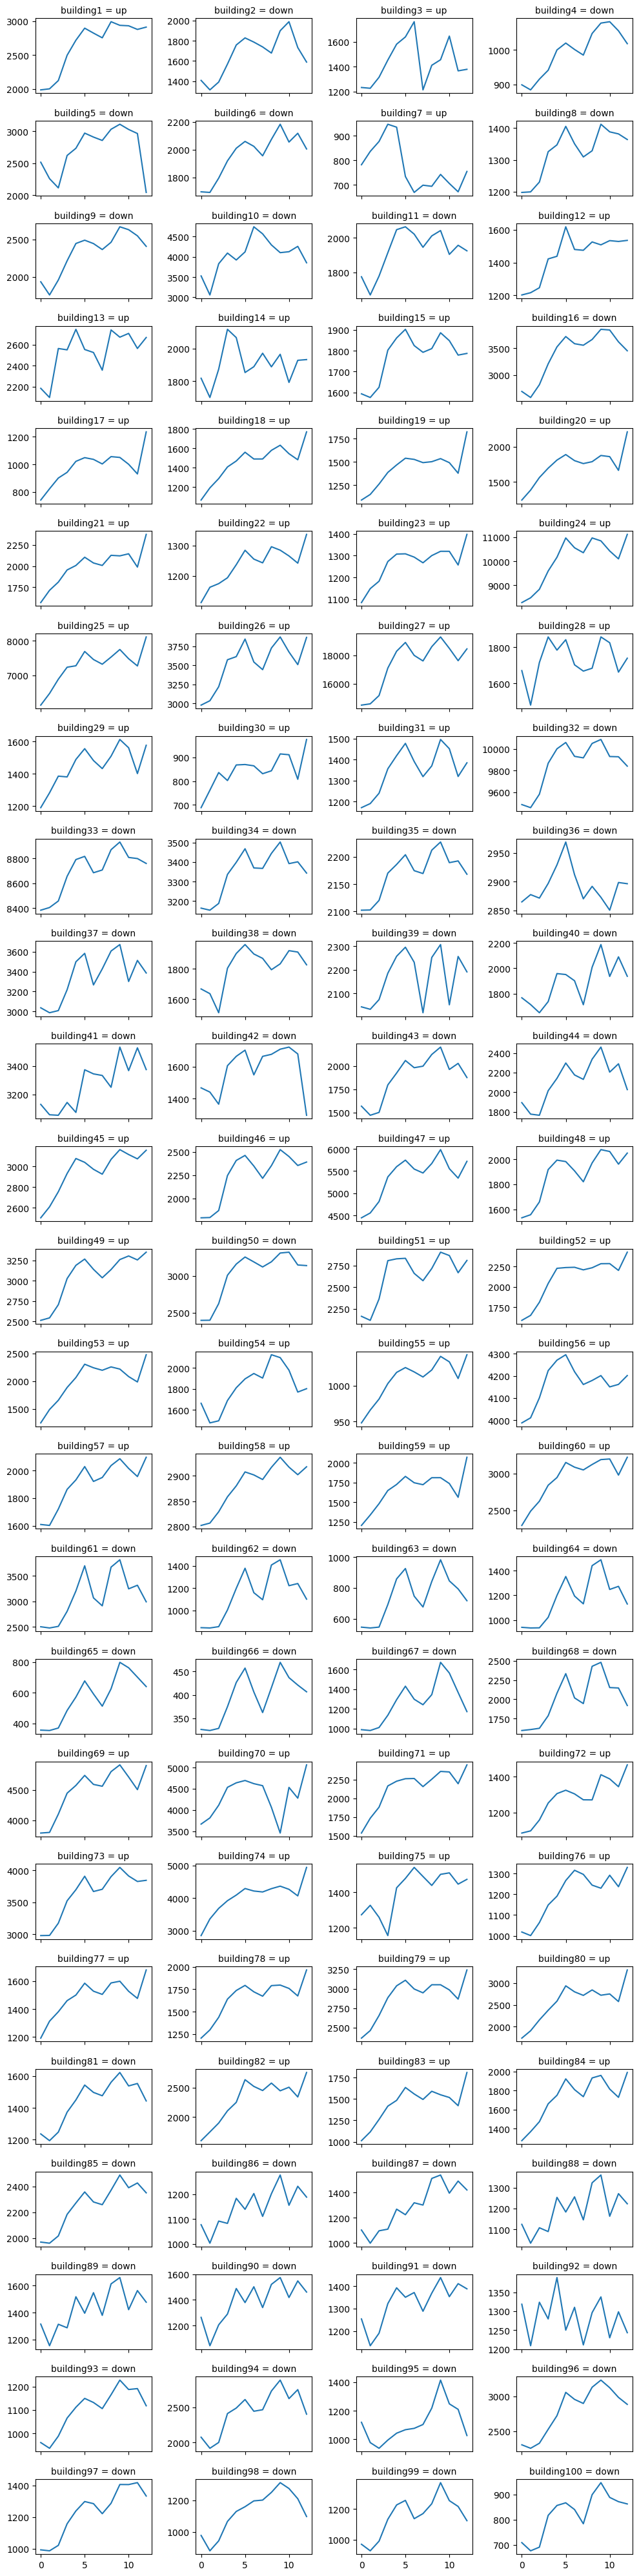

In [3]:
# #주간 평균 전력 사용량
# fig, ax = plt.subplots(25, 4, figsize=(10, 40), sharex=True)
# ax = ax.flatten()
# count = 0
# for i in range(1,101,1):
#     target_df  = merged_train_df0.loc[merged_train_df0.building_number == i].drop(columns=['num_date_time','date_time','building_type'])
#     week_avg = target_df.groupby(['week']).mean()
#     if week_avg.iloc[-2,7]> week_avg.iloc[-1,7]:
#         title = f'building{i} = down'
#         count += 1
#     else:
#          title = f'building{i} = up'
#     ax[i-1].set_title(title,fontsize = 10)
#     ax[i-1].plot(range(len(week_avg['power_consumption'])), week_avg['power_consumption'])
# print('마지막주의 전력 사용량이 떨어진 횟수:',count,"번")
# plt.tight_layout()
# plt.show()
        
        

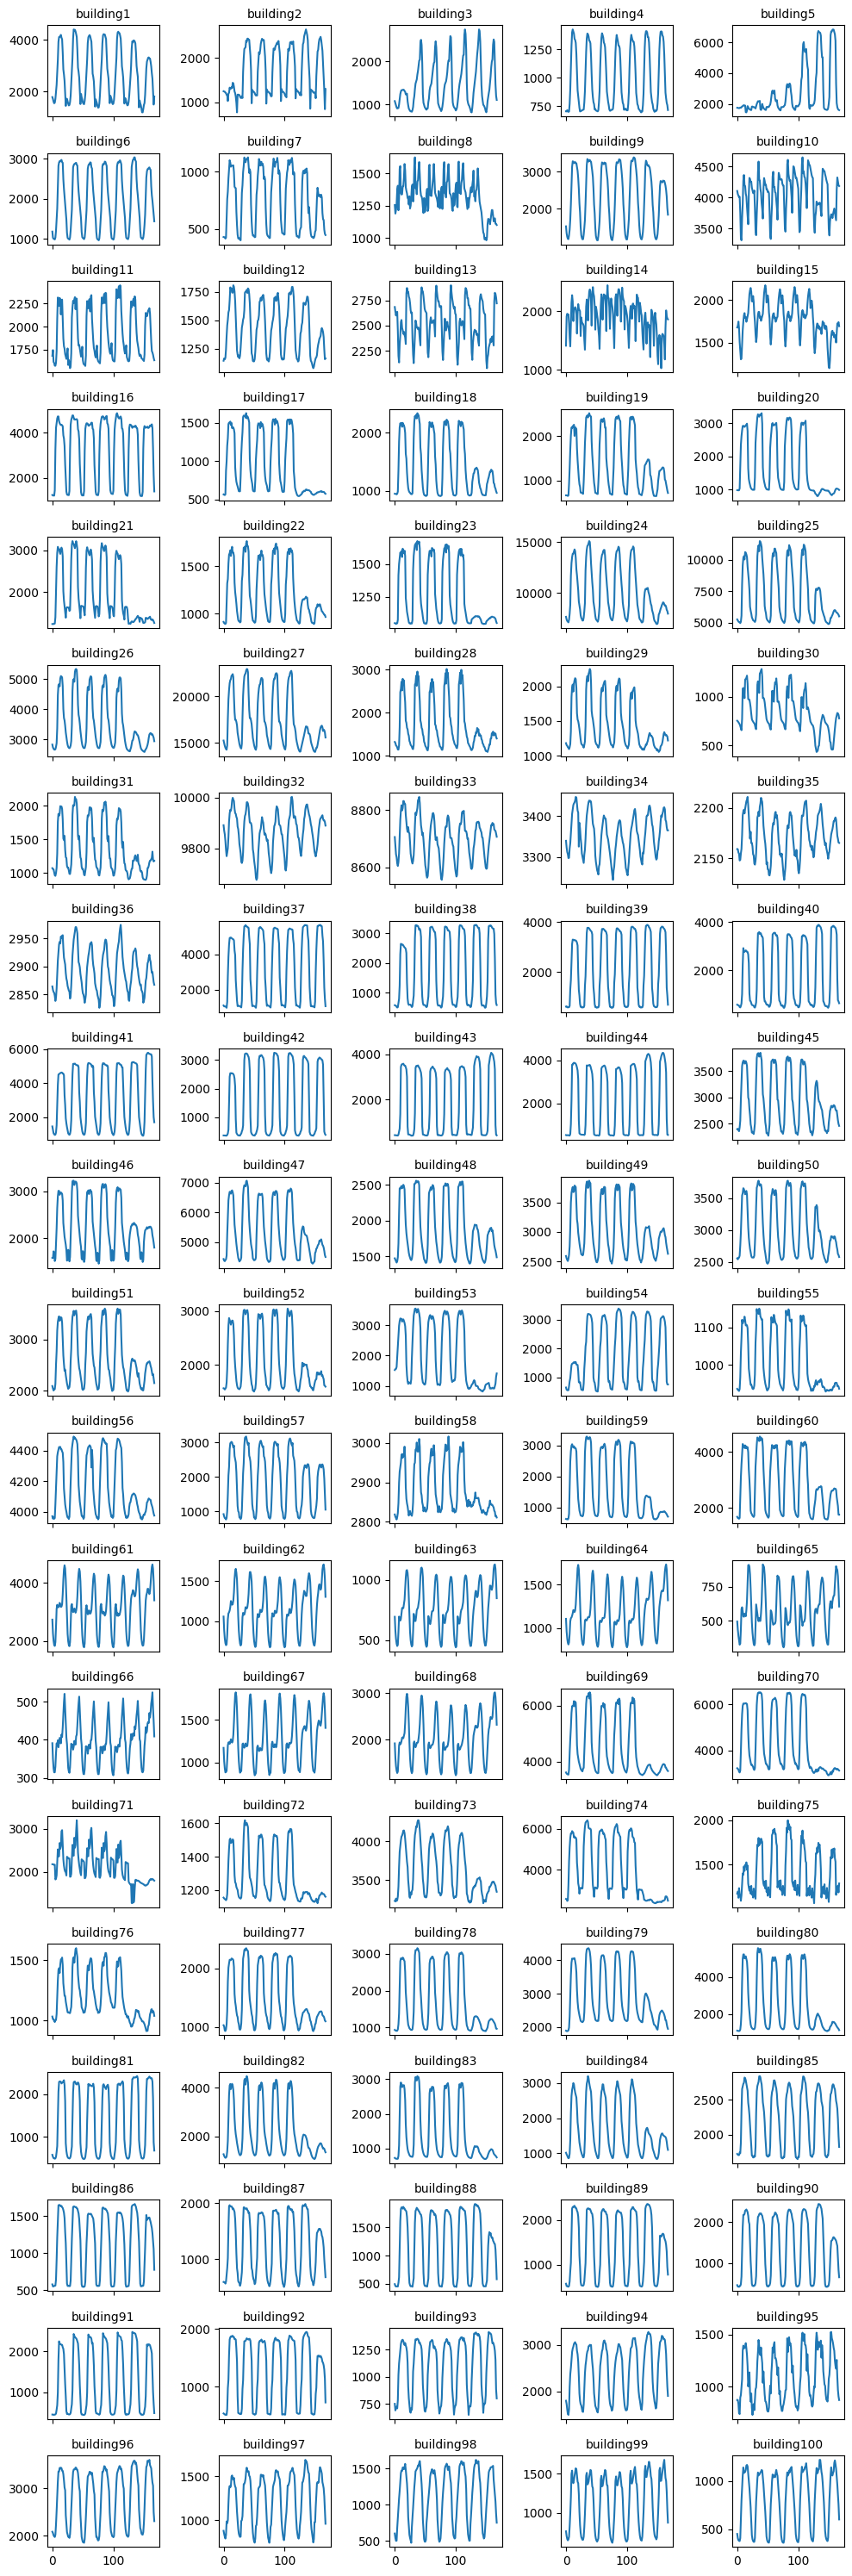

In [11]:
#day_hour_mean 전력 사용량
fig, ax = plt.subplots(20, 5, figsize=(10, 30), sharex=True)
ax = ax.flatten()
count = 0
for i in range(1,101,1):
    target_df  = merged_train_df0.loc[merged_train_df0.building_number == i].drop(columns=['num_date_time','date_time','building_type'])
    day_week_avg = target_df.groupby(['day','hour']).mean()
   
    title = f'building{i}'
    ax[i-1].set_title(title,fontsize = 10)
    ax[i-1].plot(range(len(day_week_avg['power_consumption'])), day_week_avg['power_consumption'])

plt.tight_layout()
plt.show()
        
        

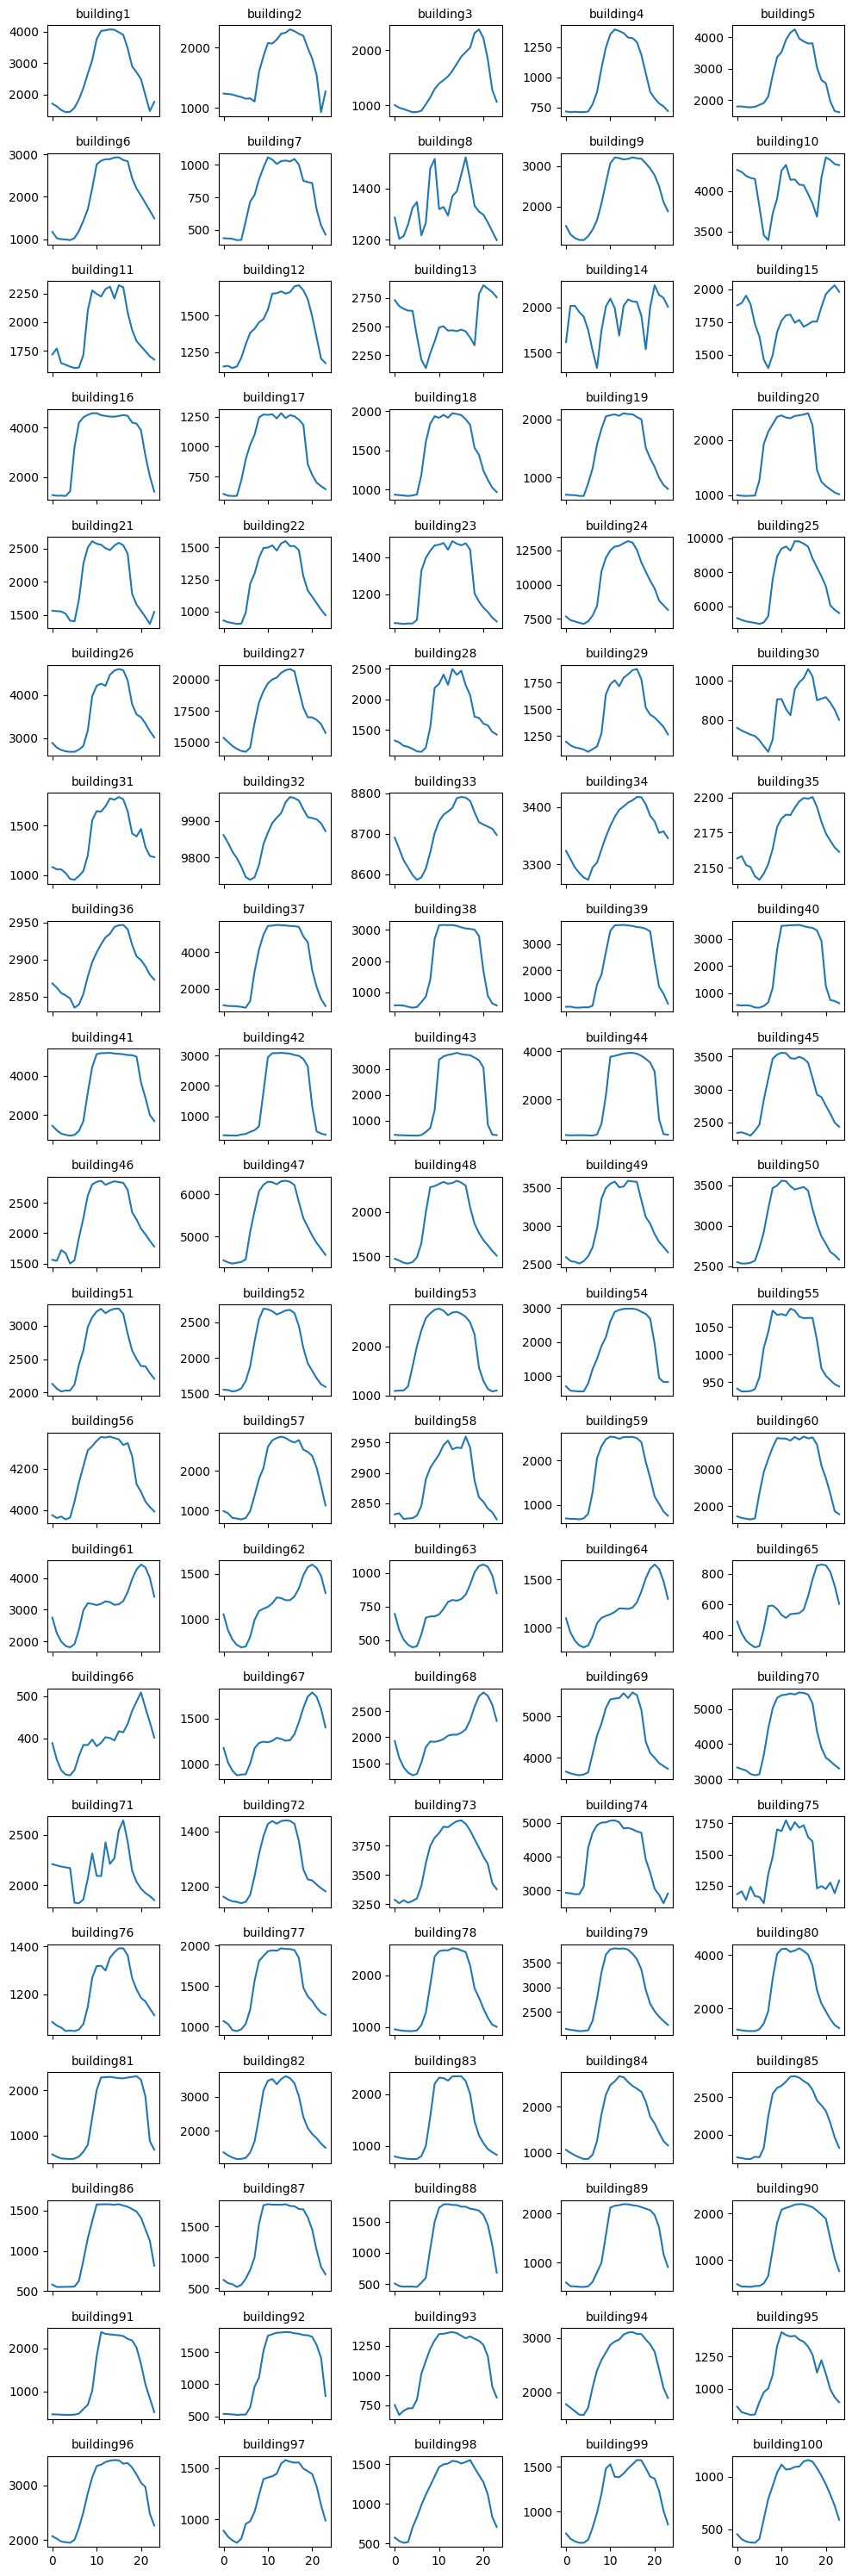

In [12]:
#hour_mean 전력 사용량
fig, ax = plt.subplots(20, 5, figsize=(10, 30), sharex=True)
ax = ax.flatten()
count = 0
for i in range(1,101,1):
    target_df  = merged_train_df0.loc[merged_train_df0.building_number == i].drop(columns=['num_date_time','date_time','building_type'])
    day_week_avg = target_df.groupby(['hour']).mean()
   
    title = f'building{i}'
    ax[i-1].set_title(title,fontsize = 10)
    ax[i-1].plot(range(len(day_week_avg['power_consumption'])), day_week_avg['power_consumption'])

plt.tight_layout()
plt.show()
        
        

In [1]:
# 결측치 처리
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# import pandas as pd


# def outlier_handing(df):

#     fig, ax = plt.subplots(100, 1, figsize=(100, 200), sharex=True)
#     ax = ax.flatten()

#     for i in range(100):
#         train_df = df.loc[df.building_number == (i+1)]
#         train_df = train_df.drop(columns = ['num_date_time','date_time','building_type'])
        
#         # 데이터 스케일링
#         scaler = StandardScaler()
#         X_scaled = scaler.fit_transform(train_df)

#         # DBSCAN 클러스터링
#         dbscan = DBSCAN(eps=4, min_samples=2)
#         labels = dbscan.fit_predict(X_scaled)
#         outlier_indices = np.where(labels == -1)[0]



#         # 이상치 대체
#         for outlier_index in outlier_indices:
#             pre_val = train_df['power_consumption'].iloc[outlier_index-1]
#             nex_val = train_df['power_consumption'].iloc[outlier_index+1]
#             # 위치 기반 인덱싱을 사용하여 값을 가져옵니다.
#             mean_value = (pre_val + nex_val) / 2
#             df['power_consumption'].iloc[(2040*i)+outlier_index] = mean_value
        
       
#         # 클러스터링 결과 시각화
#         ax[i].plot(range(len(train_df['power_consumption'])), train_df['power_consumption'], label='Original')
#         ax[i].scatter(outlier_indices, train_df['power_consumption'].iloc[outlier_indices], c='red', label='Outliers')
#         ax[i].scatter(outlier_indices, df['power_consumption'].iloc[(2040*i)+outlier_indices], c='blue', label='Outliers')
#         ax[i].set_ylabel(f'{i+1}', fontsize=20)

#     plt.show()
#     return df

# merged_train_df0 = outlier_handing(merged_train_df0)

In [58]:
# def solar(df):
#     # 24시간 동안의 sunshine 평균 계산
#     df['rolling_sunshine_mean'] = df['sunshine'].rolling(window=24).mean()

#     # rolling_sunshine_mean 값이 0.5 이상인 다음날에 solar_on 칼럼에 1 할당
#     df['solar_on'] = (df['rolling_sunshine_mean'].shift(24) >= 0.5).astype(int)

#     # rolling_sunshine_mean 칼럼 제거 (선택적)
#     df = df.drop('rolling_sunshine_mean', axis=1)
    

#     return df
# merged_train_df0 = solar(merged_train_df0)


In [ ]:
def main_time(df):
    for i in range(1,101,1):
        target_df = df.loc[df.building_number == i].drop(columns=['num_date_time','date_time','building_type'])
        target_df['main_time'] =   

In [3]:
merged_train_df1 = pd.DataFrame()
merged_pretest_df1 = pd.DataFrame()
for i in range(1,101,1):
    buff = merged_train_df0.loc[(merged_train_df0.building_number == i)] 
    merged_train_df1 = pd.concat([merged_train_df1, buff[:-168]])
    merged_pretest_df1 = pd.concat([merged_pretest_df1, buff[-168:]])

In [9]:
import pandas as pd

# 예시 데이터프레임 생성
# df = pd.DataFrame(your_data)

# 하위 5% 값을 계산하는 함수
def trimmed_mean(group):
    threshold = group['power_consumption'].quantile(0.05)
    trimmed_data = group[group['power_consumption'] > threshold]
    return trimmed_data['power_consumption'].mean()

# 시간과 요일별로 그룹화하여 평균 계산  
result = merged_train_df1.groupby(['building_number', 'day','hour']).apply(trimmed_mean).reset_index()
result.columns = ['building_number', 'day','hour', 'trimmed_mean_power_consumption']    

print(result)


       building_number  day  hour  trimmed_mean_power_consumption
0                    1    0     0                        1791.096
1                    1    0     1                        1716.912
2                    1    0     2                        1616.784
3                    1    0     3                        1553.232
4                    1    0     4                        1570.680
...                ...  ...   ...                             ...
16795              100    6    19                        1066.728
16796              100    6    20                         983.376
16797              100    6    21                         879.024
16798              100    6    22                         760.296
16799              100    6    23                         607.320

[16800 rows x 4 columns]


In [8]:
#######################################
## 건물별, 요일별, 전력시간별 소비량 평균 넣어주기
#######################################
power_mean = pd.pivot_table(merged_train_df1, values = 'power_consumption', index = ['building_number', 'hour', 'day'], aggfunc = np.mean).reset_index()
#추가
power_median = pd.pivot_table(merged_train_df1, values = 'power_consumption', index = ['building_number', 'hour', 'day'], aggfunc = np.median).reset_index()
#######################################
## 건물별, 요일별, 전력시간별 소비량 표준편차 넣어주기
#######################################
power_std = pd.pivot_table(merged_train_df1, values = 'power_consumption', index = ['building_number', 'hour', 'day'], aggfunc = np.std).reset_index()
#######################################
## 건물별 시간별 전력소비량 평균 넣어주기
#######################################
power_hour_mean = pd.pivot_table(merged_train_df1, values = 'power_consumption', index = ['building_number', 'hour'], aggfunc = np.mean).reset_index()
#추가
power_hour_median = pd.pivot_table(merged_train_df1, values = 'power_consumption', index = ['building_number', 'hour'], aggfunc = np.median).reset_index()
#######################################
## 건물별 시간별 전력소비량 표준편차 넣어주기
#######################################
power_hour_std = pd.pivot_table(merged_train_df1, values = 'power_consumption', index = ['building_number', 'hour'], aggfunc = np.std).reset_index()

def preprocessing(df):    
    
    df['holiday'] = df.apply(lambda x: 0 if x['day'] < 5 else 1, axis=1)
    
    df['date_time'] = df['date_time'].apply(lambda x : int(x[0:8]))
    df.loc[((df['month'] == 6) & (df['day'] == 2) &(df['week'] == 22), 'holiday')] = 1
    df.loc[((df['month'] == 6) & (df['day'] == 0) &(df['week'] == 23), 'holiday')] = 1
    df.loc[((df['month'] == 8) & (df['day'] == 0) &(df['week'] == 33), 'holiday')] = 1
    
    # 병합을 위한 키 설정
    merge_keys = ['building_number', 'hour', 'day']  
    # 데이터프레임 병합
    df = df.merge(power_mean[merge_keys + ['power_consumption']], on=merge_keys, how='left', suffixes=('', '_day_hour_mean'))
    df = df.merge(power_std[merge_keys + ['power_consumption']], on=merge_keys, how='left', suffixes=('', '_day_hour_std'))
    #df = df.merge(power_median[merge_keys + ['power_consumption']], on=merge_keys, how='left', suffixes=('', '_day_hour_median'))
    
    df = df.merge(power_hour_mean[merge_keys[:-1] + ['power_consumption']], on=merge_keys[:-1], how='left', suffixes=('', '_hour_mean'))
    df = df.merge(power_hour_std[merge_keys[:-1] + ['power_consumption']], on=merge_keys[:-1], how='left', suffixes=('', '_hour_std'))
    #df = df.merge(power_hour_median[merge_keys[:-1] + ['power_consumption']], on=merge_keys[:-1], how='left', suffixes=('', '_hour_median'))
    df = df.rename(columns = {'power_consumption_day_hour_mean':'day_hour_mean','power_consumption_day_hour_std':'day_hour_std','power_consumption_hour_mean':'hour_mean','power_consumption_hour_std':'hour_std'})
    
    def CDH(xs):
        ys = []
        for i in range(len(xs)):
            if i < 11:
                ys.append(np.sum(xs[:(i+1)]-26))
            else:
                ys.append(np.sum(xs[(i-11):(i+1)]-26))
        return np.array(ys)

    cdhs = np.array([])
    for num in range(1,101,1):
        temp = df[df['building_number'] == num]
        cdh = CDH(temp['temperature'].values)
        cdhs = np.concatenate([cdhs, cdh])
    df['CDH'] = cdhs
     
    ## https://dacon.io/competitions/official/235680/codeshare/2366?page=1&dtype=recent
    df['sin_time'] = np.sin(2*np.pi*df.hour/24)
    df['cos_time'] = np.cos(2*np.pi*df.hour/24)
    
    ## https://dacon.io/competitions/official/235736/codeshare/2743?page=1&dtype=recent
    df['THI'] = 9/5*df['temperature'] - 0.55*(1-df['humidity']/100)*(9/5*df['humidity']-26)+32
    ### 칼럼 추가 ###
    
    
    #################
    return df

merged_train_df2 = preprocessing(merged_train_df1)
merged_pretest_df2 = preprocessing(merged_pretest_df1)

In [16]:
print(merged_train_df2.dtypes)

num_date_time            object
building_number           int64
date_time                 int64
temperature             float64
rainfall                float64
windspeed               float64
humidity                float64
sunshine                float64
solar_radiation         float64
power_consumption       float64
hour                      int32
day                       int32
month                     int32
week                     UInt32
building_type            object
total_area              float64
cooling_area            float64
solar_power_capacity    float64
ess_capacity            float64
pcs_capacity            float64
holiday                   int64
day_hour_mean           float64
day_hour_std            float64
hour_mean               float64
hour_std                float64
CDH                     float64
sin_time                float64
cos_time                float64
THI                     float64
dtype: object


In [18]:
def data_train(df):
    
    grouped = df.groupby(['building_number', 'date_time'])
    df['max_power'] = grouped['power_consumption'].transform(np.max)
    df['min_power'] = grouped['power_consumption'].transform(np.min)
    
    grouped2 = df.groupby(['building_number', 'day'])
    df['max_power'] = grouped2['max_power'].transform(np.mean)
    df['min_power'] = grouped2['min_power'].transform(np.mean)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.fillna(0)
    df['THI_cat'] = pd.cut(df['THI'], bins = [0,68,75,80,200],labels=[1,2,3,4])
    return df.drop(columns=['num_date_time','date_time','building_type','sunshine','pcs_capacity','ess_capacity','solar_power_capacity','solar_radiation','total_area','cooling_area'])

def data_test(df):
    grouped_train = merged_train_df.groupby(['building_number', 'day'])
    max_power = grouped_train['max_power'].median()
    min_power = grouped_train['min_power'].median()
    max_power_df = max_power.reset_index()
    min_power_df = min_power.reset_index()

    # 테스트 데이터에 max_power_median와 min_power_median을 추가
    df = pd.merge(df, max_power_df, on=['building_number', 'day'])
    df = pd.merge(df, min_power_df, on=['building_number', 'day'])
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.fillna(0)
    df['THI_cat'] = pd.cut(df['THI'], bins = [0,68,75,80,200],labels=[1,2,3,4])

    return df.drop(columns=['num_date_time','date_time','building_type','sunshine','solar_radiation','pcs_capacity','ess_capacity','solar_power_capacity','total_area','cooling_area'])
#실제 구동용
merged_train_df =data_train(merged_train_df2)
merged_pretest_df =data_test(merged_pretest_df2)

train, pretest 저장

In [ ]:
## test용
merged_train_df.to_csv(f'./data/train_split_wsw_{t}.csv')
merged_pretest_df.to_csv(f'./data/pretest_wsw_{t}.csv')

빌딩별로 csv생성

In [ ]:
#train,test
train_df  = pd.read_csv((f'./data/train_split_wsw_{t}.csv')).drop(columns='Unnamed: 0')
pretest_df  = pd.read_csv((f'./data/pretest_wsw_{t}.csv')).drop(columns='Unnamed: 0')
for i in range(1,101,1):
    tr = train_df.loc[train_df.building_number==i].reset_index()
    tr = tr.drop(columns=['index'])
    te = pretest_df.loc[pretest_df.building_number==i].reset_index()
    te = te.drop(columns=['index'])
    tr.to_csv(f'./pretest/train_building{i}.csv')
    te.to_csv(f'./pretest/pretest_building{i}.csv')

In [ ]:
# #혹시 vaild를 나눠야 할수도있을때만 사용
# train_df  = pd.read_csv((f'./split/train_fianl_wsw_{t}.csv')).drop(columns='Unnamed: 0')
# test_df  = pd.read_csv((f'./split/test_fianl_wsw_{t}.csv')).drop(columns='Unnamed: 0')
# for i in range(1,101,1):
#     tr = train_df.loc[train_df.building_number==i].reset_index()
#     tr = tr.drop(columns=['index'])
#     te = test_df.loc[test_df.building_number==i].reset_index()
#     te = te.drop(columns=['index'])
#     tr.to_csv(f'./split/train_building{i}.csv')
#     te.to_csv(f'./split/test_building{i}.csv')